# Importation

In [7]:
import cv2
import numpy as np
import os
import time
import warnings
from sklearn.metrics.pairwise import cosine_similarity
import sys
import re
from nltk import download
import pandas as pd
from tqdm import tqdm
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk import pos_tag, RegexpParser, word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install pyLDAvis
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import nltk

# Download NLTK resources
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')

from PyPDF2 import PdfReader
from PIL import ImageGrab, Image
import fitz
import pytesseract
from pdf2image import convert_from_path
import pyautogui

# This Python environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here are several helpful packages to load in
import easyocr
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g., pd.read_csv)
import re
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hamma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\hamma\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\hamma\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hamma\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
C:\Users\hamma\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [4]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Transforming to pictures

In [2]:
# PDF file paths
pdfPMBOK = "PMBOK6-2017.pdf" #431-494
pdfPMI = "practice-standard-project-risk-management.pdf" #1-116
output_folder_1="PMBOOKimgs"
output_folder_2="Practiceimgs"

In [3]:
#pdf2image
def convert_pdf_to_images(pdf_file_path, output_folder, start_page, end_page):
    images = convert_from_path(pdf_file_path, output_folder=output_folder, fmt='png', first_page=start_page, last_page=end_page, output_file="page")

    print("Done.")

In [4]:
convert_pdf_to_images(pdfPMBOK, output_folder_1, 431, 494)

Done.


In [5]:
convert_pdf_to_images(pdfPMI, output_folder_2, 1, 116)

Done.


# Extracting Figures

### openCV:

In [6]:
def detect_shapes(image_path, min_contour_area=1000):
    # Read the image
    image = cv2.imread("PMBOOKimgs/"+image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Use Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    k=0
    for contour in contours:
        k=k+1
        # Calculate the contour area
        area = cv2.contourArea(contour)

        # If the contour area is greater than the minimum threshold
        if area >= min_contour_area:
            # Approximate the contour as a polygon
            epsilon = 0.04 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)

            # Check if the polygon has 4 vertices, indicating a rectangle
            if len(approx) == 4:
                # Get the bounding box coordinates of the rectangle
                x, y, w, h = cv2.boundingRect(contour)

                # Define a region of interest (ROI) using the rectangle coordinates
                roi = image[y:y+h, x:x+w]

                # Save the ROI as an image for inspection
                cv2.imwrite("screenshots/"+image_path+"/"+str(k)+"detected__"+image_path, roi)                
                

In [7]:
detect_shapes("page0001-445.png")

In [8]:
for k in os.listdir("PMBOOKimgs/"):
    os.makedirs("screenshots/"+k, exist_ok=True)
    detect_shapes(k)

# Extracting Texts from images

# deleting figures in  image

In [9]:
def detect_and_remove_rectangles(image_path, min_contour_area=1000):
    # Read the image
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Use Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask with the same size as the image, initialized to white
    mask = np.ones_like(image) * 255

    for contour in contours:
        # Calculate the contour area
        area = cv2.contourArea(contour)

        # If the contour area is greater than the minimum threshold
        if area >= min_contour_area:
            # Approximate the contour as a polygon
            epsilon = 0.04 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)

            # Check if the polygon has 4 vertices, indicating a rectangle
            if len(approx) == 4:
                # Get the bounding box coordinates of the rectangle
                x, y, w, h = cv2.boundingRect(contour)

                # Set the region corresponding to the rectangle to black in the mask
                mask[y:y+h, x:x+w] = 0

    # Use the mask to copy the non-rectangle parts of the image to a new image
    result = cv2.bitwise_and(image, mask)

    return result


# Get a list of all image files in the folder
image_files = [f for f in os.listdir(output_folder_1) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Specify the output folder
output_folder = "output_folder_PMBOOKimgs"

# Check if the output folder exists, and if not, create it
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Process each image in the folder
for image_file in image_files:
    # Construct the full path to the image file
    image_path = os.path.join(output_folder_1, image_file)

    # Call the detect_and_remove_rectangles function
    output_image = detect_and_remove_rectangles(image_path)

    # Define the output file path for each processed image
    output_file = os.path.join(output_folder, image_file)

    # Save the processed image to the output folder
    cv2.imwrite(output_file, output_image)

print("Processing completed. Processed images are saved in the '{}' folder.".format(output_folder))

Processing completed. Processed images are saved in the 'output_folder_PMBOOKimgs' folder.


# tables with nodes 

In [20]:
pip install fpdf2


Note: you may need to restart the kernel to use updated packages.


In [29]:
import os
from fpdf import FPDF
from PIL import Image

# Input folder containing image files
input_folder = "output_folder_PMBOOKimgs"

# Output PDF file path
output_pdf_path = "PmbokI2P.pdf"

def convert_images_to_pdf(input_folder, output_pdf_path):
    image_files = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    pdf = FPDF()

    # Create a PDF document
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.add_page()

    for image_file in image_files:
        # Add each image to the PDF page
        pdf.image(image_file, x=10, y=10, w=190)
        pdf.add_page()

    # Output the PDF to the specified file
    pdf.output(output_pdf_path)

# Call the function to convert images to a PDF
convert_images_to_pdf(input_folder, output_pdf_path)

print(f"Images in folder '{input_folder}' have been converted to PDF: {output_pdf_path}")


Images in folder 'output_folder_PMBOOKimgs' have been converted to PDF: PmbokI2P.pdf


In [23]:
pip install tabula-py


Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install camelot-py[all]


In [ ]:
pip install camelot


In [42]:
pip install pdfplumber


In [38]:
pip install PyPDF2 tabula-py


Note: you may need to restart the kernel to use updated packages.


In [50]:
pip install PyMuPDF


In [12]:
import tabula

# Define the page range you want to extract
start_page = 431
end_page = 494

# Read the PDF and extract tables using tabula-py for the specified pages
tables = tabula.read_pdf(pdfPMBOK, pages=f"{start_page}-{end_page}")

# Create a custom document structure with tables as dictionaries
document = {"title": "My PDF Document", "tables": []}

# Define a function to filter tables based on criteria (e.g., minimum rows and columns)
def is_actual_table(table, min_rows=2, min_columns=2):
    return len(table) >= min_rows and len(table.columns) >= min_columns

# Enumerate tables, filter out non-table content, and add them to the document
for page, table in enumerate(tables, start=start_page):
    if is_actual_table(table):
        table_node = {"page": page, "table_data": table}
        document["tables"].append(table_node)

# Now you have a custom document structure with filtered tables as dictionaries

# You can loop through the extracted tables and print the filtered table data
for table_node in document["tables"]:
    page = table_node["page"]
    table_data = table_node["table_data"]
    print(f"Table on Page {page}:\n{table_data}\n")


Table on Page 432:
  .5 Organizational process  Unnamed: 0 .5 Enterprise environmental  \
0                    assets         NaN                     factors   
1                       NaN         NaN   .6 Organizational process   
2        Tools & Techniques         NaN                      assets   
3        .1 Expert judgment         NaN                         NaN   
4          .2 Data analysis         0.2          Tools & Techniques   

                  assets                    assets.1  
0                    NaN                         NaN  
1  .2 Tools & Techniques       .2 Tools & Techniques  
2     .1 Expert judgment         .1 Expert judgmentu  
3      .2 Data gathering           .2 Data gathering  
4       .3 Data analysis  .3 Interpersodnal and team  

Table on Page 433:
               .3 Meetings         .1 Expert judgment  \
0                      NaN          .2 Data gathering   
1                  Outputs                        NaN   
2                      NaN       

# Using EasyOCR now to detect words:(DO NOT RUN)

In [13]:
# Initialize the EasyOCR reader with the desired languages
reader = easyocr.Reader(['en'])

# Specify the folder containing the images
folder_path = 'output_folder_PMBOOKimgs'

# List all image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Sort the image files based on their names
image_files.sort()

# Define the image to be skipped
skip_image = 'page0001-432.png'

# Create a text file to store the OCR results
output_file = 'ocr_results_PMBOOKimgs.txt'

# Loop through each image file
with open(output_file, 'w', encoding='utf-8') as txt_file:
    for image_file in image_files:
        # Check if the current image file matches the one to be skipped
        if image_file == skip_image:
            print(f"Skipping {skip_image}")
            continue  # Skip this image and move to the next one

        # Construct the full path to the image
        image_path = os.path.join(folder_path, image_file)

        # Load the image and convert it to a NumPy array
        image = np.array(Image.open(image_path))

        # Perform OCR on the image
        results = reader.readtext(image)

        # Write the OCR results for the current image to the text file
        for (text, bounding_box, prob) in results:
            txt_file.write(f"{bounding_box}\n")

print(f"OCR results have been saved to {output_file}")

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Skipping page0001-432.png
OCR results have been saved to ocr_results_PMBOOKimgs.txt


# Extracting texts from figures to text file:

# (DO NOT RUN)

In [ ]:
def extract_text_from_blocks(image_folder, output_folder, zoom_factor=1.0, min_characters=5):
    # Iterate through the images in the folder
    for filename in os.listdir(image_folder):
        if filename.endswith(('.jpg', '.png', '.jpeg')):  # Adjust the file extensions as needed
            # Construct the full path to the image
            image_path = os.path.join(image_folder, filename)

            # Read the image
            image = cv2.imread(image_path)

            # Convert the image to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Use adaptive thresholding to segment text from the background
            _, threshold = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

            # Find contours of the blocks
            contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Initialize a counter for generating unique filenames
            counter = 1

            for contour in contours:
                # Extract the region of interest (ROI) for each block
                x, y, w, h = cv2.boundingRect(contour)
                block_roi = image[y:y+h, x:x+w]

                # Apply the zoom factor to the block ROI
                if zoom_factor != 1.0:
                    block_roi = cv2.resize(block_roi, None, fx=zoom_factor, fy=zoom_factor)

                # Use Tesseract to extract text from the block ROI
                text = pytesseract.image_to_string(Image.fromarray(block_roi))

                # Check if the extracted text contains at least 5 characters
                if len(text.strip()) >= min_characters:
                    # Print the extracted text
                    print(text)

                    # Generate a unique filename based on the counter
                    output_file = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_{counter}.txt")

                    # Increment the counter
                    counter += 1

                    # Save the extracted text to a file
                    with open(output_file, 'w', encoding='utf-8') as text_file:
                        text_file.write(text)

# Example usage with a zoom factor of 2.0 and a minimum of 5 characters:
input_folder = 'PMBOOKimgs'
output_folder = 'output_figures'
extract_text_from_blocks(input_folder, output_folder, zoom_factor=2.0, min_characters=10)

# now extracting data from textfile(used because easyocr is too heavy to compile each time) into a dataframe:

In [95]:
import re
import pandas as pd

def extract_concepts_and_definitions_from_text(text_file):
    with open(text_file, 'r', encoding='utf-8') as file:
        text = file.read()

    concepts_and_definitions = []
    current_concept = ""
    current_concept_name = ""
    current_definition = ""

    lines = text.split('\n')

    for line in lines:
        # Check if the line matches the pattern for a concept
        if re.match(r'(\d+(\.\d+)*)\s+(.+)', line):
            if current_concept:
                # Append the current concept and definition to the list as a tuple
                concepts_and_definitions.append((current_concept, current_concept_name, current_definition))

            # Split the line into concept and definition
            concept_match = re.match(r'(\d+(\.\d+)*)\s+(.+)', line)
            current_concept = concept_match.group(1)
            current_concept_name = concept_match.group(3)
            current_definition = ""
        else:
            # If the line does not match the pattern, consider it part of the definition
            current_definition += "\n" + line

    # Append the last concept and definition to the list
    concepts_and_definitions.append((current_concept, current_concept_name, current_definition))

    # Create a DataFrame
    df = pd.DataFrame(concepts_and_definitions, columns=["Number", "Concept", "Description"])
    return df

# Example of usage
text_file_path = 'ocr_results_PMBOOKimgs.txt'  # Replace with the path to your text file
df = extract_concepts_and_definitions_from_text(text_file_path)

# Print or process the DataFrame
print(df)


       Number                                Concept  \
0        11.1                   Plan Risk Management   
1        11.2                         Identify Risks   
2        11.3      Perform Qualitative Risk Analysis   
3        11.4     Perform Quantitative Risk Analysis   
4        11.5                    Plan Risk Responses   
..        ...                                    ...   
113  11.7.3.1           WORK PERFORMANCE INFORMATION   
114  11.7.3.2                        CHANGE REQUESTS   
115  11.7.3.3        PROJECT MANAGEMENT PLAN UPDATES   
116  11.7.3.4              PROJECT DOCUMENTS UPDATES   
117  11.7.3.5  ORGANIZATIONAL PROCESS ASSETS UPDATES   

                                           Description  
0    \nThe process of defining how to conduct risk ...  
1    \nThe process of identifying individual projec...  
2    \nThe process of prioritizing individual proje...  
3    \nThe process ofnumerically analyzing the comb...  
4    \nThe process of developing options, 

In [96]:
df.rename(columns={'Concept': 'Title'}, inplace=True)

In [97]:
df

,Number,Title,Description
0,11.1,Plan Risk Management,\nThe process of defining how to conduct risk ...
1,11.2,Identify Risks,\nThe process of identifying individual projec...
2,11.3,Perform Qualitative Risk Analysis,\nThe process of prioritizing individual proje...
3,11.4,Perform Quantitative Risk Analysis,\nThe process ofnumerically analyzing the comb...
4,11.5,Plan Risk Responses,"\nThe process of developing options, selecting..."
...,...,...,...
113,11.7.3.1,WORK PERFORMANCE INFORMATION,\nDescribed in Section 4.5.1.3. Work performan...
114,11.7.3.2,CHANGE REQUESTS,\nY\nDescribed in Section 4.3.3.4. The Monitor...
115,11.7.3.3,PROJECT MANAGEMENT PLAN UPDATES,\nchange to the project management plan goes t...
116,11.7.3.4,PROJECT DOCUMENTS UPDATES,\nProject documents that may be updated as a r...


# Normalize :

In [98]:
# Apply text cleaning to the "Definition" column
df["Description"] = df["Description"].apply(lambda x: x.lower())

In [99]:
df

,Number,Title,Description
0,11.1,Plan Risk Management,\nthe process of defining how to conduct risk ...
1,11.2,Identify Risks,\nthe process of identifying individual projec...
2,11.3,Perform Qualitative Risk Analysis,\nthe process of prioritizing individual proje...
3,11.4,Perform Quantitative Risk Analysis,\nthe process ofnumerically analyzing the comb...
4,11.5,Plan Risk Responses,"\nthe process of developing options, selecting..."
...,...,...,...
113,11.7.3.1,WORK PERFORMANCE INFORMATION,\ndescribed in section 4.5.1.3. work performan...
114,11.7.3.2,CHANGE REQUESTS,\ny\ndescribed in section 4.3.3.4. the monitor...
115,11.7.3.3,PROJECT MANAGEMENT PLAN UPDATES,\nchange to the project management plan goes t...
116,11.7.3.4,PROJECT DOCUMENTS UPDATES,\nproject documents that may be updated as a r...


In [100]:
# Function to extract "Described In" values
def extract_described_in(definition):
    described_in_matches = re.findall(r'(?:\(?)described in section (\d+(\.\d+)*)', definition)
    if described_in_matches:
        return ', '.join([match[0] for match in described_in_matches])
    else:
        return None
# Apply the function to the DataFrame
df['Described In'] = df['Description'].apply(extract_described_in)

# Display the DataFrame
df

,Number,Title,Description,Described In
0,11.1,Plan Risk Management,\nthe process of defining how to conduct risk ...,None
1,11.2,Identify Risks,\nthe process of identifying individual projec...,None
2,11.3,Perform Qualitative Risk Analysis,\nthe process of prioritizing individual proje...,None
3,11.4,Perform Quantitative Risk Analysis,\nthe process ofnumerically analyzing the comb...,None
4,11.5,Plan Risk Responses,"\nthe process of developing options, selecting...",None
...,...,...,...,...
113,11.7.3.1,WORK PERFORMANCE INFORMATION,\ndescribed in section 4.5.1.3. work performan...,4.5.1.3
114,11.7.3.2,CHANGE REQUESTS,\ny\ndescribed in section 4.3.3.4. the monitor...,4.3.3.4
115,11.7.3.3,PROJECT MANAGEMENT PLAN UPDATES,\nchange to the project management plan goes t...,None
116,11.7.3.4,PROJECT DOCUMENTS UPDATES,\nproject documents that may be updated as a r...,"4.1.3.2, 4.3.3.3, 4.4.3.1, 11.2.3.1, 11.2.3.2"


In [101]:
# Function to remove "described in" part
def remove_described_in(definition):
    return re.sub(r'\(?\s*described in section \d+(\.\d+)*\s*\)?', '', definition)
# Apply the function to the "Definition" column
df['Description'] = df['Description'].apply(remove_described_in)
# Display the DataFrame
df

,Number,Title,Description,Described In
0,11.1,Plan Risk Management,\nthe process of defining how to conduct risk ...,None
1,11.2,Identify Risks,\nthe process of identifying individual projec...,None
2,11.3,Perform Qualitative Risk Analysis,\nthe process of prioritizing individual proje...,None
3,11.4,Perform Quantitative Risk Analysis,\nthe process ofnumerically analyzing the comb...,None
4,11.5,Plan Risk Responses,"\nthe process of developing options, selecting...",None
...,...,...,...,...
113,11.7.3.1,WORK PERFORMANCE INFORMATION,. work performance information includes inform...,4.5.1.3
114,11.7.3.2,CHANGE REQUESTS,\ny. the monitor risks process may result in a...,4.3.3.4
115,11.7.3.3,PROJECT MANAGEMENT PLAN UPDATES,\nchange to the project management plan goes t...,None
116,11.7.3.4,PROJECT DOCUMENTS UPDATES,\nproject documents that may be updated as a r...,"4.1.3.2, 4.3.3.3, 4.4.3.1, 11.2.3.1, 11.2.3.2"


In [102]:
def extract_figures(definition):
    figure_matches = re.findall(r'figure (\d{1,2}-\d{1,2}[a-zA-Z]{0,6})', definition)
    if figure_matches:
        figures = ', '.join(figure_matches)
        return figures
    else:
        return None
# Apply the function to extract figures and add them to the "Figure" column
df['Figure'] = df['Description'].apply(extract_figures)

# Display the DataFrame
df

,Number,Title,Description,Described In,Figure
0,11.1,Plan Risk Management,\nthe process of defining how to conduct risk ...,None,None
1,11.2,Identify Risks,\nthe process of identifying individual projec...,None,None
2,11.3,Perform Qualitative Risk Analysis,\nthe process of prioritizing individual proje...,None,None
3,11.4,Perform Quantitative Risk Analysis,\nthe process ofnumerically analyzing the comb...,None,None
4,11.5,Plan Risk Responses,"\nthe process of developing options, selecting...",None,None
...,...,...,...,...,...
113,11.7.3.1,WORK PERFORMANCE INFORMATION,. work performance information includes inform...,4.5.1.3,None
114,11.7.3.2,CHANGE REQUESTS,\ny. the monitor risks process may result in a...,4.3.3.4,None
115,11.7.3.3,PROJECT MANAGEMENT PLAN UPDATES,\nchange to the project management plan goes t...,None,None
116,11.7.3.4,PROJECT DOCUMENTS UPDATES,\nproject documents that may be updated as a r...,"4.1.3.2, 4.3.3.3, 4.4.3.1, 11.2.3.1, 11.2.3.2",None


In [103]:
import pandas as pd

# Filter the original DataFrame to get rows with non-None values in the "Figure" column
non_none_figures_df = df[df['Figure'].notna()]

# Display the resulting DataFrame
non_none_figures_df

,Number,Title,Description,Described In,Figure
6,11.7,Monitor Risks,\nthe process of monitoring the implementation...,None,11-1
7,11.1,PLAN RISK MANAGEMENT,\nplan risk management is the process of defin...,None,"11-3, 11-2, 11-3"
19,11.1.3.1,RISK MANAGEMENT PLAN,\nthe risk management plan is a component of t...,11.3.2.6,"11-4, 11-5, 11-5"
20,11.2,IDENTIFY RISKS,\nidentify risks is the process of identifying...,None,"11-6, 11-7, 11-7"
22,11.2.1.1,PROJECT MANAGEMENT PLAN,. project management plan components include b...,"4.2.3.1, 6.1.3.1, 7.1.3.1, 8.1.3.1, 9.1.3.1, 1...",11-4
39,11.3,PERFORM QUALITATIVE RISK ANALYSIS,\nperform qualitative risk analysis is the pro...,None,"11-8, 11-9, 11-8, 11-9"
50,11.3.2.5,RISK CATEGORIZATION,\nrisks to the project can be categorized by s...,None,11-4
51,11.3.2.6,DATA REPRESENTATION,\ndata representation techniques that can be u...,None,"11-5, 11-10, 11-10"
55,11.4,PERFORM QUANTITATIVE RISK ANALYSIS,\nperform quantitative risk analysis is the pr...,None,"11-11, 11-12, 11-11, 11-12"
66,11.4.2.5,DATA ANALYSIS,\ndata analysis techniques that can be used du...,None,"11-13, 11-13, 11-14, 11-14, 11-15, 11-15"


# References

In [104]:
import os

# Specify the directory path where your figures are located
figures_directory = "PMBOOKimgs/"

# Function to generate figure URLs
def generate_figure_url(figure_number):
    # Construct the filename based on the figure number
    filename = f"figure{figure_number}.png"
    # Construct the full file URL using the directory path
    figure_url = os.path.join(figures_directory, filename)
    return figure_url

# Apply the function to the "Figure" column to create the "Figure_URL" column
df['References'] = df['Figure'].apply(generate_figure_url)

# Display the DataFrame with figure URLs
df

,Number,Title,Description,Described In,Figure,References
0,11.1,Plan Risk Management,\nthe process of defining how to conduct risk ...,None,None,PMBOOKimgs/figureNone.png
1,11.2,Identify Risks,\nthe process of identifying individual projec...,None,None,PMBOOKimgs/figureNone.png
2,11.3,Perform Qualitative Risk Analysis,\nthe process of prioritizing individual proje...,None,None,PMBOOKimgs/figureNone.png
3,11.4,Perform Quantitative Risk Analysis,\nthe process ofnumerically analyzing the comb...,None,None,PMBOOKimgs/figureNone.png
4,11.5,Plan Risk Responses,"\nthe process of developing options, selecting...",None,None,PMBOOKimgs/figureNone.png
...,...,...,...,...,...,...
113,11.7.3.1,WORK PERFORMANCE INFORMATION,. work performance information includes inform...,4.5.1.3,None,PMBOOKimgs/figureNone.png
114,11.7.3.2,CHANGE REQUESTS,\ny. the monitor risks process may result in a...,4.3.3.4,None,PMBOOKimgs/figureNone.png
115,11.7.3.3,PROJECT MANAGEMENT PLAN UPDATES,\nchange to the project management plan goes t...,None,None,PMBOOKimgs/figureNone.png
116,11.7.3.4,PROJECT DOCUMENTS UPDATES,\nproject documents that may be updated as a r...,"4.1.3.2, 4.3.3.3, 4.4.3.1, 11.2.3.1, 11.2.3.2",None,PMBOOKimgs/figureNone.png


In [105]:
# Supprimer la colonne nommée 'Figure' du DataFrame
df.drop(columns=['Figure'], inplace=True)


# Cleaning Data :

In [48]:
def clean_text(text):
    # Remove special characters and symbols (retain letters, numbers, and basic punctuation)
    cleaned_text = re.sub(r'[^a-zA-Z0-9.,!? ]', '', text)
    
    # Remove extra spaces and trim leading/trailing spaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text

In [29]:
df['Definition'] = df['Description'].apply(clean_text)

In [108]:
df

,Number,Title,Description,Described In,References,Definition
0,11.1,Plan Risk Management,\nthe process of defining how to conduct risk ...,None,PMBOOKimgs/figureNone.png,the process of defining how to conduct risk ma...
1,11.2,Identify Risks,\nthe process of identifying individual projec...,None,PMBOOKimgs/figureNone.png,the process of identifying individual project ...
2,11.3,Perform Qualitative Risk Analysis,\nthe process of prioritizing individual proje...,None,PMBOOKimgs/figureNone.png,the process of prioritizing individual project...
3,11.4,Perform Quantitative Risk Analysis,\nthe process ofnumerically analyzing the comb...,None,PMBOOKimgs/figureNone.png,the process ofnumerically analyzing the combin...
4,11.5,Plan Risk Responses,"\nthe process of developing options, selecting...",None,PMBOOKimgs/figureNone.png,"the process of developing options, selecting s..."
...,...,...,...,...,...,...
113,11.7.3.1,WORK PERFORMANCE INFORMATION,. work performance information includes inform...,4.5.1.3,PMBOOKimgs/figureNone.png,. work performance information includes inform...
114,11.7.3.2,CHANGE REQUESTS,\ny. the monitor risks process may result in a...,4.3.3.4,PMBOOKimgs/figureNone.png,y. the monitor risks process may result in a c...
115,11.7.3.3,PROJECT MANAGEMENT PLAN UPDATES,\nchange to the project management plan goes t...,None,PMBOOKimgs/figureNone.png,change to the project management plan goes thr...
116,11.7.3.4,PROJECT DOCUMENTS UPDATES,\nproject documents that may be updated as a r...,"4.1.3.2, 4.3.3.3, 4.4.3.1, 11.2.3.1, 11.2.3.2",PMBOOKimgs/figureNone.png,project documents that may be updated as a res...


In [30]:
new

,Number,Title,Description,Described In,References,Definition,sentence
0,11.1,Plan Risk Management,\nthe process of defining how to conduct risk ...,None,PMBOOKimgs/figureNone.png,the process of define how to conduct risk mana...,[the process of define how to conduct risk man...
1,11.2,Identify Risks,\nthe process of identifying individual projec...,None,PMBOOKimgs/figureNone.png,the process of identify individual project ris...,[the process of identify individual project ri...
2,11.3,Perform Qualitative Risk Analysis,\nthe process of prioritizing individual proje...,None,PMBOOKimgs/figureNone.png,the process of prioritize individual project r...,[the process of prioritize individual project ...
3,11.4,Perform Quantitative Risk Analysis,\nthe process ofnumerically analyzing the comb...,None,PMBOOKimgs/figureNone.png,the process ofnumerically analyze the combine ...,[the process ofnumerically analyze the combine...
4,11.5,Plan Risk Responses,"\nthe process of developing options, selecting...",None,PMBOOKimgs/figureNone.png,"the process of develop option , select strateg...","[the process of develop option , select strate..."
...,...,...,...,...,...,...,...
113,11.7.3.1,WORK PERFORMANCE INFORMATION,. work performance information includes inform...,4.5.1.3,PMBOOKimgs/figureNone.png,. work performance information include informa...,"[., work performance information include infor..."
114,11.7.3.2,CHANGE REQUESTS,\ny. the monitor risks process may result in a...,4.3.3.4,PMBOOKimgs/figureNone.png,y. the monitor risk process may result in a ch...,[y. the monitor risk process may result in a c...
115,11.7.3.3,PROJECT MANAGEMENT PLAN UPDATES,\nchange to the project management plan goes t...,None,PMBOOKimgs/figureNone.png,change to the project management plan go throu...,[change to the project management plan go thro...
116,11.7.3.4,PROJECT DOCUMENTS UPDATES,\nproject documents that may be updated as a r...,"4.1.3.2, 4.3.3.3, 4.4.3.1, 11.2.3.1, 11.2.3.2",PMBOOKimgs/figureNone.png,project document that may be update as a resul...,[project document that may be update as a resu...


## KeyWords with KeyBert

In [31]:
pip install keybert

Note: you may need to restart the kernel to use updated packages.


In [115]:
from keybert import KeyBERT
kw_model = KeyBERT(model='all-mpnet-base-v2')

def extract_key_words(text):
    keywords = kw_model.extract_keywords(text, 

                                        keyphrase_ngram_range=(2, 3), 

                                         stop_words='english', 

                                         highlight=False,

                                         top_n=5)
    keywords_list= list(dict(keywords).keys())
    return keywords_list

#print(keywords_list)

In [116]:
new['kw_bert'] = [[] for _ in range(len(new))]

In [ ]:
new['kw_bert']=new['Definition'].apply(lambda x : extract_key_words(x))

In [ ]:
new

In [36]:
new.loc[9]["Definition"]

'. the project charter document the highlevel project description and boundary highlevel requirement , and risks.402part 1guide6slnoe'

In [37]:
new.loc[9]["kw_bert"]

['highlevel project description',
 'highlevel project',
 'highlevel requirement',
 'charter document highlevel',
 'boundary highlevel requirement']

In [ ]:
df=new

# Synonymes from keywords

In [24]:
import pandas as pd
df = pd.read_csv("final.csv")

In [25]:
df = df.drop(['Synonyms', 'topics'], axis=1)

In [26]:
df = df.rename(columns={'Concept': 'Title'})

In [27]:
df = df.rename(columns={'References': 'Figures'})

In [28]:
df.to_csv('final3.csv', index=False)

In [29]:
df

,Number,Title,Description,Described In,Definition,sentence,kw_bert,Figures
0,11.1,Plan Risk Management,\nthe process of defining how to conduct risk ...,NaN,the process of define how to conduct risk mana...,['the process of define how to conduct risk ma...,"['risk management activity', 'conduct risk man...",PMBOOKimgs/figureNone.png
1,11.2,Identify Risks,\nthe process of identifying individual projec...,NaN,the process of identify individual project ris...,['the process of identify individual project r...,"['project risk', 'project risk document', 'pro...",PMBOOKimgs/figureNone.png
2,11.3,Perform Qualitative Risk Analysis,\nthe process of prioritizing individual proje...,NaN,the process of prioritize individual project r...,['the process of prioritize individual project...,"['project risk analysisor', 'project risk', 'i...",PMBOOKimgs/figureNone.png
3,11.4,Perform Quantitative Risk Analysis,\nthe process ofnumerically analyzing the comb...,NaN,the process ofnumerically analyze the combine ...,['the process ofnumerically analyze the combin...,"['identifiedindividual project risk', 'project...",PMBOOKimgs/figureNone.png
4,11.5,Plan Risk Responses,"\nthe process of developing options, selecting...",NaN,"the process of develop option , select strateg...","['the process of develop option , select strat...","['project risk exposure', 'project risk', 'ove...",PMBOOKimgs/figureNone.png
...,...,...,...,...,...,...,...,...
113,11.7.3.1,WORK PERFORMANCE INFORMATION,. work performance information includes inform...,4.5.1.3,. work performance information include informa...,"['.', 'work performance information include in...","['work performance information', 'project risk...",PMBOOKimgs/figureNone.png
114,11.7.3.2,CHANGE REQUESTS,\ny. the monitor risks process may result in a...,4.3.3.4,y. the monitor risk process may result in a ch...,['y. the monitor risk process may result in a ...,"['monitor risk process', 'plan change request'...",PMBOOKimgs/figureNone.png
115,11.7.3.3,PROJECT MANAGEMENT PLAN UPDATES,\nchange to the project management plan goes t...,NaN,change to the project management plan go throu...,['change to the project management plan go thr...,"['change project management', 'plan organizati...",PMBOOKimgs/figureNone.png
116,11.7.3.4,PROJECT DOCUMENTS UPDATES,\nproject documents that may be updated as a r...,"4.1.3.2, 4.3.3.3, 4.4.3.1, 11.2.3.1, 11.2.3.2",project document that may be update as a resul...,['project document that may be update as a res...,"['projects risk register', 'risk process inclu...",PMBOOKimgs/figureNone.png


In [36]:
pip install -U sentence-transformers


Note: you may need to restart the kernel to use updated packages.


# SBERT pré-entraîné l output twila barcha cv pas

In [45]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util


# Charger un modèle SBERT pré-entraîné
model = SentenceTransformer('inkoziev/sbert_synonymy')
embeddings = model.encode(df['kw_bert'].tolist())

# Fonction pour trouver des synonymes basés sur SBERT et la similarité cosinus
def find_synonyms(row):
    s1 = row['kw_bert']
    v1 = model.encode(s1)
    synonyms = []

    for i2, sentence in enumerate(df['Definition']):
        if i2 != row.name:  # Exclure la même phrase
            s = util.pytorch_cos_sim(v1, embeddings[i2]).item()
            if s > 0.7:  # Ajustez le seuil de similarité selon vos besoins
                synonyms.append(sentence)
    
    return synonyms

# Appliquer la fonction pour trouver des synonymes à chaque ligne du DataFrame
df['synonyms'] = df.apply(find_synonyms, axis=1)

# Afficher le DataFrame avec les synonymes
print(df)


       Number                                  Title  \
0        11.1                   Plan Risk Management   
1        11.2                         Identify Risks   
2        11.3      Perform Qualitative Risk Analysis   
3        11.4     Perform Quantitative Risk Analysis   
4        11.5                    Plan Risk Responses   
..        ...                                    ...   
113  11.7.3.1           WORK PERFORMANCE INFORMATION   
114  11.7.3.2                        CHANGE REQUESTS   
115  11.7.3.3        PROJECT MANAGEMENT PLAN UPDATES   
116  11.7.3.4              PROJECT DOCUMENTS UPDATES   
117  11.7.3.5  ORGANIZATIONAL PROCESS ASSETS UPDATES   

                                           Description  \
0    \nthe process of defining how to conduct risk ...   
1    \nthe process of identifying individual projec...   
2    \nthe process of prioritizing individual proje...   
3    \nthe process ofnumerically analyzing the comb...   
4    \nthe process of developing opti

# Synonymes from KeyWords

In [30]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util


# Charger le modèle SBERT avancé
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Fonction pour trouver des synonymes pour la colonne 'kw_bert'
def find_synonyms(row):
    kw_bert = row['kw_bert']
    synonyms = []
    for index, other_row in df.iterrows():
        if other_row['kw_bert'] != kw_bert:
            similarity = util.pytorch_cos_sim(model.encode(kw_bert, convert_to_tensor=True), model.encode(other_row['kw_bert'], convert_to_tensor=True)).item()
            if similarity > 0.9:  # Ajustez le seuil de similarité selon vos besoins
                synonyms.append(other_row['kw_bert'])
    return synonyms

# Appliquer la fonction pour trouver des synonymes et stocker les résultats dans la colonne 'synonyms'
df['synonyms'] = df.apply(find_synonyms, axis=1)



In [31]:
df

,Number,Title,Description,Described In,Definition,sentence,kw_bert,Figures,synonyms
0,11.1,Plan Risk Management,\nthe process of defining how to conduct risk ...,NaN,the process of define how to conduct risk mana...,['the process of define how to conduct risk ma...,"['risk management activity', 'conduct risk man...",PMBOOKimgs/figureNone.png,[]
1,11.2,Identify Risks,\nthe process of identifying individual projec...,NaN,the process of identify individual project ris...,['the process of identify individual project r...,"['project risk', 'project risk document', 'pro...",PMBOOKimgs/figureNone.png,"[['project risk', 'project risk common', 'proj..."
2,11.3,Perform Qualitative Risk Analysis,\nthe process of prioritizing individual proje...,NaN,the process of prioritize individual project r...,['the process of prioritize individual project...,"['project risk analysisor', 'project risk', 'i...",PMBOOKimgs/figureNone.png,[]
3,11.4,Perform Quantitative Risk Analysis,\nthe process ofnumerically analyzing the comb...,NaN,the process ofnumerically analyze the combine ...,['the process ofnumerically analyze the combin...,"['identifiedindividual project risk', 'project...",PMBOOKimgs/figureNone.png,[]
4,11.5,Plan Risk Responses,"\nthe process of developing options, selecting...",NaN,"the process of develop option , select strateg...","['the process of develop option , select strat...","['project risk exposure', 'project risk', 'ove...",PMBOOKimgs/figureNone.png,"[['project risk exposure', 'project risk pose'..."
...,...,...,...,...,...,...,...,...,...
113,11.7.3.1,WORK PERFORMANCE INFORMATION,. work performance information includes inform...,4.5.1.3,. work performance information include informa...,"['.', 'work performance information include in...","['work performance information', 'project risk...",PMBOOKimgs/figureNone.png,[]
114,11.7.3.2,CHANGE REQUESTS,\ny. the monitor risks process may result in a...,4.3.3.4,y. the monitor risk process may result in a ch...,['y. the monitor risk process may result in a ...,"['monitor risk process', 'plan change request'...",PMBOOKimgs/figureNone.png,[]
115,11.7.3.3,PROJECT MANAGEMENT PLAN UPDATES,\nchange to the project management plan goes t...,NaN,change to the project management plan go throu...,['change to the project management plan go thr...,"['change project management', 'plan organizati...",PMBOOKimgs/figureNone.png,[]
116,11.7.3.4,PROJECT DOCUMENTS UPDATES,\nproject documents that may be updated as a r...,"4.1.3.2, 4.3.3.3, 4.4.3.1, 11.2.3.1, 11.2.3.2",project document that may be update as a resul...,['project document that may be update as a res...,"['projects risk register', 'risk process inclu...",PMBOOKimgs/figureNone.png,[]


In [32]:
df['kw_bert'][1]

"['project risk', 'project risk document', 'project risk source', 'overall project risk', 'individual project risk']"

In [33]:
df['synonyms'][1]

["['project risk', 'project risk common', 'project risk example', 'project risk alsoact', 'overall project risk']",
 "['project risk source', 'project risk', 'risk analysis', 'risk source uncertainty', 'individual project risk']"]

# les vercteurs ddes synonyms

In [34]:
from transformers import BertTokenizer, BertModel
import torch
import pandas as pd

# Load a pre-trained BERT model and tokenizer (replace with the appropriate model)
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Function to generate BERT embeddings for a given text
def generate_bert_embeddings(text):
    tokens = tokenizer.encode(text, add_special_tokens=True)
    input_ids = torch.tensor(tokens).unsqueeze(0)
    with torch.no_grad():
        embeddings = model(input_ids)[0].mean(dim=1).squeeze().numpy()
    return embeddings

# Apply the function to generate BERT embeddings for "kw_bert" and create a new "SynonymsKW" feature
df['SynonymsKW'] = df['kw_bert'].apply(lambda text: generate_bert_embeddings(text))

# Function to add synonyms to the "Definition" feature using BERT embeddings and "SynonymsKW"
def add_synonyms_definition(row):
    definition = row['Definition']
    synonyms_kw = row['SynonymsKW']

    # You can implement a function to find synonyms based on BERT embeddings and synonyms_kw
    # For simplicity, we'll just concatenate them, but you should replace this with your synonym generation logic
    synonyms_definition = f"{definition} {synonyms_kw}"

    return synonyms_definition

# Apply the function to the DataFrame to enrich the "Definition" feature with synonyms
df['Definition'] = df.apply(add_synonyms_definition, axis=1)

# Display the updated DataFrame
df

,Number,Title,Description,Described In,Definition,sentence,kw_bert,Figures,synonyms,SynonymsKW
0,11.1,Plan Risk Management,\nthe process of defining how to conduct risk ...,NaN,the process of define how to conduct risk mana...,['the process of define how to conduct risk ma...,"['risk management activity', 'conduct risk man...",PMBOOKimgs/figureNone.png,[],"[0.10421263, 0.42657995, 0.34032828, -0.364220..."
1,11.2,Identify Risks,\nthe process of identifying individual projec...,NaN,the process of identify individual project ris...,['the process of identify individual project r...,"['project risk', 'project risk document', 'pro...",PMBOOKimgs/figureNone.png,"[['project risk', 'project risk common', 'proj...","[-0.100361414, 0.3353802, 0.15903097, -0.29788..."
2,11.3,Perform Qualitative Risk Analysis,\nthe process of prioritizing individual proje...,NaN,the process of prioritize individual project r...,['the process of prioritize individual project...,"['project risk analysisor', 'project risk', 'i...",PMBOOKimgs/figureNone.png,[],"[0.108589485, 0.32915118, 0.18415046, -0.14617..."
3,11.4,Perform Quantitative Risk Analysis,\nthe process ofnumerically analyzing the comb...,NaN,the process ofnumerically analyze the combine ...,['the process ofnumerically analyze the combin...,"['identifiedindividual project risk', 'project...",PMBOOKimgs/figureNone.png,[],"[-0.16861854, 0.34130716, 0.20885508, -0.21614..."
4,11.5,Plan Risk Responses,"\nthe process of developing options, selecting...",NaN,"the process of develop option , select strateg...","['the process of develop option , select strat...","['project risk exposure', 'project risk', 'ove...",PMBOOKimgs/figureNone.png,"[['project risk exposure', 'project risk pose'...","[0.011465572, 0.33703935, 0.20835248, -0.26486..."
...,...,...,...,...,...,...,...,...,...,...
113,11.7.3.1,WORK PERFORMANCE INFORMATION,. work performance information includes inform...,4.5.1.3,. work performance information include informa...,"['.', 'work performance information include in...","['work performance information', 'project risk...",PMBOOKimgs/figureNone.png,[],"[0.078955665, 0.30567336, 0.3159312, -0.202558..."
114,11.7.3.2,CHANGE REQUESTS,\ny. the monitor risks process may result in a...,4.3.3.4,y. the monitor risk process may result in a ch...,['y. the monitor risk process may result in a ...,"['monitor risk process', 'plan change request'...",PMBOOKimgs/figureNone.png,[],"[0.021280846, 0.29271778, 0.39091426, -0.21902..."
115,11.7.3.3,PROJECT MANAGEMENT PLAN UPDATES,\nchange to the project management plan goes t...,NaN,change to the project management plan go throu...,['change to the project management plan go thr...,"['change project management', 'plan organizati...",PMBOOKimgs/figureNone.png,[],"[0.025491253, 0.44292024, 0.3300802, -0.394126..."
116,11.7.3.4,PROJECT DOCUMENTS UPDATES,\nproject documents that may be updated as a r...,"4.1.3.2, 4.3.3.3, 4.4.3.1, 11.2.3.1, 11.2.3.2",project document that may be update as a resul...,['project document that may be update as a res...,"['projects risk register', 'risk process inclu...",PMBOOKimgs/figureNone.png,[],"[-0.05025936, 0.37145317, 0.34699553, -0.28260..."


In [36]:
# Comptez le nombre de NaN dans la colonne 'Synonyms'
nan_count = df['synonyms'].isnull().sum()


In [37]:
nan_count

0

In [39]:
df['synonyms'] = df['synonyms'].apply(lambda x: ' '.join(x))



In [40]:
df.to_csv("after-syn.csv", index=False)

#  Summary : (hugging face T5ForCOnditionalGeneration)

In [ ]:
!pip install gensim
!pip install bert-extractive-summarizer

In [42]:
import pandas as pd
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Charger le modèle T5 pré-entraîné et le tokenizer
model = T5ForConditionalGeneration.from_pretrained("t5-base")
tokenizer = T5Tokenizer.from_pretrained("t5-base")

# Définir la fonction pour générer un résumé
def summarize_description(description):
    if pd.notna(description):  # Vérifiez si la valeur n'est pas nulle
        input_text = "summarize: " + description
        input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True)
        summary_ids = model.generate(input_ids, max_length=150, num_beams=4, length_penalty=2.0, early_stopping=True)
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        return summary
    else:
        return ""  # Remplacez les valeurs nulles par une chaîne vide

C:\Users\asus tuf\anaconda3\lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\asus tuf\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
# Apply the 'create_summary' function to the 'Description' column to create the 'Summary' column
df['Summary'] = df['Definition'].apply(summarize_description)


In [44]:
df

,Number,Title,Description,Described In,References,Definition,sentence,kw_bert,Topic_Name
0,11.1,Plan Risk Management,\nthe process of defining how to conduct risk ...,None,PMBOOKimgs/figureNone.png,the process of define how to conduct risk mana...,[the process of define how to conduct risk man...,"[risk management activity, conduct risk manage...",process define conduct risk management
1,11.2,Identify Risks,\nthe process of identifying individual projec...,None,PMBOOKimgs/figureNone.png,the process of identify individual project ris...,[the process of identify individual project ri...,"[project risk, project risk document, project ...",project risk process identify individual
2,11.3,Perform Qualitative Risk Analysis,\nthe process of prioritizing individual proje...,None,PMBOOKimgs/figureNone.png,the process of prioritize individual project r...,[the process of prioritize individual project ...,"[project risk analysisor, project risk, indivi...",process prioritize individual project risk
3,11.4,Perform Quantitative Risk Analysis,\nthe process ofnumerically analyzing the comb...,None,PMBOOKimgs/figureNone.png,the process ofnumerically analyze the combine ...,[the process ofnumerically analyze the combine...,"[identifiedindividual project risk, project ri...",project process ofnumerically analyze combine
4,11.5,Plan Risk Responses,"\nthe process of developing options, selecting...",None,PMBOOKimgs/figureNone.png,"the process of develop option , select strateg...","[the process of develop option , select strate...","[project risk exposure, project risk, overall ...",project risk process develop option
...,...,...,...,...,...,...,...,...,...
113,11.7.3.1,WORK PERFORMANCE INFORMATION,. work performance information includes inform...,4.5.1.3,PMBOOKimgs/figureNone.png,. work performance information include informa...,"[., work performance information include infor...","[work performance information, project risk ma...",information risk occur response work
114,11.7.3.2,CHANGE REQUESTS,\ny. the monitor risks process may result in a...,4.3.3.4,PMBOOKimgs/figureNone.png,y. the monitor risk process may result in a ch...,[y. the monitor risk process may result in a c...,"[monitor risk process, plan change request, ri...",risk process change request project
115,11.7.3.3,PROJECT MANAGEMENT PLAN UPDATES,\nchange to the project management plan goes t...,None,PMBOOKimgs/figureNone.png,change to the project management plan go throu...,[change to the project management plan go thro...,"[change project management, plan organization ...",change project management plan go
116,11.7.3.4,PROJECT DOCUMENTS UPDATES,\nproject documents that may be updated as a r...,"4.1.3.2, 4.3.3.3, 4.4.3.1, 11.2.3.1, 11.2.3.2",PMBOOKimgs/figureNone.png,project document that may be update as a resul...,[project document that may be update as a resu...,"[projects risk register, risk process include,...",risk may update project process


#  Tokenization :

from nltk.tokenize import word_tokenize
def tokenize(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)
    return tokens

In [41]:
from nltk.tokenize import word_tokenize
def tokenize(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)
    return tokens

#  POS-TAGGING

In [42]:
def pos_tagging(text):
    # Tokenize the text into words
    words = tokenize(text)

    # Perform POS tagging
    pos_tags = pos_tag(words)

    return pos_tags

#  STOPWORDS

In [43]:
def remove_stopwords_from_list(text):
    
    pos_tags=pos_tagging(text)
    word_list=tokenize(text)
    # Define a list of POS tags for words to keep (e.g., nouns and adjectives)
    allowed_pos_tags = ['VBD',  # Verb, past tense
        'VBG',  # Verb, gerund or present participle
        'VBN',  # Verb, past participle
        'VBP',  # Verb, non-3rd person singular present
        'VBZ',  # Verb, 3rd person singular present
        'PRP','NN','VB',"MD", 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS',",",".","!","?"]  # Nouns and adjectives
    
    # Filter out stopwords based on POS tags
    filtered_words = [word for word, pos_tag in zip(word_list, pos_tags) if pos_tag[1]
                      in allowed_pos_tags]
    
    return ' '.join(filtered_words)

#  Chunking :

In [44]:
import networkx as nx
import matplotlib.pyplot as plt
def chunk_words_by_meaning(text):
    # Tokenize the text into words
    words = tokenize(text)

    # Perform POS tagging
    pos_tags = pos_tagging(text)
    chunks = []
    # Define a grammar for chunking (NP: Noun Phrase)
    # Define a grammar for chunking
    grammar = r"""
        NP: {<JJ.*>*<PRP|NN.*>+}   # chunk determiners, adjectives, personal pronouns, and nouns
        VP: {<MD>*<VB.*>+}      # chunk verb phrases with optional NP
        CHUNK: {<NP><VP>+<NP>}  # chunk relation with NP-VP-NP pattern
    """
    
    # Create a chunk parser with the defined grammar
    
    chunk_parser = RegexpParser(grammar)

    
    # Apply chunking to POS-tagged words
    tree = chunk_parser.parse(pos_tags)

        # Extract phrases from the tree
    for subtree in tree.subtrees():
        if subtree.label() == 'CHUNK':
            listt=[]
            for sub in subtree:
                NP = ' '.join([token for token, _ in sub.leaves()])
                listt.append(NP)
            chunks.append(listt)
    print(chunks)

    return chunks,tree


#### after this phase it should be returned a list of chunks cleaned

#  Relationship & Concepts:

In [54]:
# Assuming df is your existing DataFrame
df_columns = df.columns
neww = pd.DataFrame(columns=df_columns)

In [55]:
neww

,Number,Title,Description,Described In,Definition,sentence,kw_bert,Figures,synonyms,SynonymsKW,Subject,Relation,Object


In [59]:
import pandas as pd

# Assuming df is your existing DataFrame
# Initialize neww as an empty DataFrame with the same columns
neww = pd.DataFrame(columns=df.columns)

for index, row in df.iterrows():
    text = row["Definition"]
    cleaned_text = remove_stopwords_from_list(clean_text(text))
    chunks, tree = chunk_words_by_meaning(cleaned_text)
    
    for k in chunks:
        new_row = {}
        for col in df.columns:
            new_row[col] = row[col]
        new_row['Subject'] = k[0]
        new_row['Relation'] = k[1]
        new_row['Object'] = k[2]
        neww = pd.concat([neww, pd.DataFrame([new_row])], ignore_index=True)

# Display the resulting DataFrame
print(neww)


[]
[['process', 'identify', 'individual project risk source']]
[['process', 'prioritize', 'individual project risk']]
[['process analyze', 'combine', 'effect']]
[]
[]
[['they', 'overlap', 'interact way thatcannot'], ['pmboke guide.395ctionepifonotkey concept project risk managementail project', 'be', 'risky they'], ['vary degree complexity', 'aim', 'deliverbenefit they'], ['respond stakeholder expectation', 'be', 'conflict change organization'], ['project risk', 'control', 'intentional mannerin order'], ['value balance risk', 'reward.project', 'risk management aim identify manage risk'], ['unmanage risk', 'have', 'potential cause project deviate plan'], ['level project project', 'contain', 'individual risk'], ['define followsindividual project risk', 'be', 'uncertain event condition it occur'], ['project objectivesoverall project risk', 'be', 'effect uncertainty project'], ['represent exposure stakeholder implication variation', 'projectoutcome', 'positive negative.individual project r

[['identify risk', 'be', 'process identify individual project risk source'], ['overall project risk', 'anddocumente', 'characteristic key benefit process'], ['overall project risk it', 'bring', 'information project team'], ['appropriatelyto identify risk process', 'be perform', 'project input'], ['risk datum flow risk', 'consider', 'individual project risk source'], ['participant riskidentification activity', 'may include following', 'project manager project team member'], ['project risk', 'specialistif', 'assign'], ['areoftenparticipant risk identification project stakeholder', 'should be encourage', 'identify individual projectrisk'], ['it', 'be', 'important involve project team they'], ['maintain sense ownership andresponsibility', 'identify', 'individual project risk'], ['consistent format', 'should be', 'use risk statement toensure risk'], ['individual project risk', 'may be', 'nominate part identify risk process'], ['preliminary risk response', 'may be', 'identifiedand record'], 

[['project document', 'may be', 'update result process'], ['assumption constraint', 'may be revisit', 'changedthe assumption log'], ['issue log', 'should be', 'update capture'], ['uncoveredor change log issues.lesson', 'learn', 'register'], ['learn register', 'can be', 'update withinformation technique'], ['effective identify risk', 'improve', 'performance']]
[['qualitative risk analysis', 'be', 'process prioritize individual project risk'], ['key benefit thisprocess', 'be', 'it'], ['process', 'be perform', 'project input'], ['output process', 'be', 'depict figure'], ['figure depict data', 'flowdiagram', 'processperform'], ['qualitative risk analysis priority', 'identify', 'individual project risk'], ['objective risk', 'occur', 'other factor'], ['such assessment aresubjective they', 'be base', 'perception risk project team'], ['address bias', 'be', 'key part facilitator role'], ['evaluation quality availableinformation individual project risk', 'help clarify', 'assessment risk importan

[['project document', 'can be consider', 'input process'], ['assumption', 'may form', 'input'], ['basis estimate use', 'planning', 'ofthe project'], ['quantitative risk analysis process', 'may includeinformation', 'estimate purpose'], ['start pointwhich cost variabilityis', 'evaluated.cost', 'forecast .. forecast'], ['tocomplete performance index tcpi', 'may becompare result', 'quantitative cost risk analysis determine confidence ievel'], ['duration estimate', 'starting', 'point whichschedule variability'], ['quantitative schedule risk analysis', 'be', 'compare order determine confidencelevel'], ['associate achieve', 'targets430part', 'notresource requirement .. resource requirement'], ['fromwhich variability', 'be', 'evaluated.risk register'], ['risk report', 'describe', 'source'], ['forecast', 'may be', 'compare result quantitativeschedule risk analysis determine confidence level']]
[['environmental factor', 'can influence perform', 'quantitative risk analysis process']]
[['organizat

[['environmental factor', 'can influence', 'plan risk response process'], ['limitedto risk appetite', 'threshold', 'key stakeholder']]
[['cthe organizational process asset', 'can influence', 'plan risk response process'], ['reporthistorical database andlesson', 'learn', 'repository']]
[]
[['expertise', 'should be', 'consider individual group'], ['andoverall project risk response strategiesexpert input', 'may be', 'seek individual particular']]
[['technique', 'can be', 'use process'], ['overall project risk', 'may be undertakenduring', 'structured semistructure interview'], ['other stakeholder mayalso', 'be', 'interview'], ['necessary interviewer', 'should promote', 'environment trust confidentiality theinterview']]
[['interpersonal team skill', 'can be', 'use process'], ['use facilitation', 'improve', 'effectiveness develop response'], ['facilitator', 'can help risk', 'owner risk']]
[['alternative strategy', 'may be', 'consider deal threat'], ['followsescalate escalation', 'be', 'appro

[['project document', 'may be', 'update result carry process'], ['plan', 'risk', 'response process'], ['new assumptionsmay', 'be make', 'new constraintsbe identify'], ['assumption constraint', 'may be revisit', 'assumption log'], ['update new information.cost forecast .. cost forecast', 'may change', 'result plan risk responseslesson'], ['learn register', 'be', 'update informationabout risk response'], ['activity', 'relate', 'agreedupon risk response'], ['necessaryresource', 'should be', 'allocate action associate risk response plan'], ['include suitablyqualifie experience personnel', 'execute', 'agreedupon action project team specificbudget time allowance action'], ['risk register', 'be', 'update appropriate risk response'], ['update risk register', 'may include be', 'limit response'], ['symptom warn sign risk', 'occurrencebudget', 'schedule activity'], ['implement choose responsescontingency plan risk trigger', 'call', 'executionfallback plan'], ['risk', 'have occur', 'primary respon

[['organizational process asset', 'be', 'update result monitor risk process']]
       Number                                  Title  \
0        11.2                         Identify Risks   
1        11.3      Perform Qualitative Risk Analysis   
2        11.4     Perform Quantitative Risk Analysis   
3        11.7                          Monitor Risks   
4        11.7                          Monitor Risks   
..        ...                                    ...   
720  11.7.3.4              PROJECT DOCUMENTS UPDATES   
721  11.7.3.4              PROJECT DOCUMENTS UPDATES   
722  11.7.3.4              PROJECT DOCUMENTS UPDATES   
723  11.7.3.4              PROJECT DOCUMENTS UPDATES   
724  11.7.3.5  ORGANIZATIONAL PROCESS ASSETS UPDATES   

                                           Description  \
0    the process of identify individual project ris...   
1    the process of prioritize individual project r...   
2    the process ofnumerically analyze the combine ...   
3    the process

In [60]:
neww

,Number,Title,Description,Described In,Definition,sentence,kw_bert,Figures,synonyms,SynonymsKW,Subject,Relation,Object
0,11.2,Identify Risks,the process of identify individual project ris...,NaN,the process of identify individual project ris...,['the process of identify individual project r...,"['project risk', 'project risk document', 'pro...",PMBOOKimgs/figureNone.png,"['project risk', 'project risk common', 'proje...","[-0.100361414, 0.3353802, 0.15903097, -0.29788...",process,identify,individual project risk source
1,11.3,Perform Qualitative Risk Analysis,the process of prioritize individual project r...,NaN,the process of prioritize individual project r...,['the process of prioritize individual project...,"['project risk analysisor', 'project risk', 'i...",PMBOOKimgs/figureNone.png,,"[0.108589485, 0.32915118, 0.18415046, -0.14617...",process,prioritize,individual project risk
2,11.4,Perform Quantitative Risk Analysis,the process ofnumerically analyze the combine ...,NaN,the process ofnumerically analyze the combine ...,['the process ofnumerically analyze the combin...,"['identifiedindividual project risk', 'project...",PMBOOKimgs/figureNone.png,,"[-0.16861854, 0.34130716, 0.20885508, -0.21614...",process analyze,combine,effect
3,11.7,Monitor Risks,the process of monitor the implementation of a...,NaN,the process of monitor the implementation of a...,['the process of monitor the implementation of...,"['project risk process', 'project risk managem...",PMBOOKimgs/figurePMBOOKimgs/figure11-1.png.png,"['project risk management', 'project riskmanag...","[0.04863735, 0.34235623, 0.18667592, -0.173904...",they,overlap,interact way thatcannot
4,11.7,Monitor Risks,the process of monitor the implementation of a...,NaN,the process of monitor the implementation of a...,['the process of monitor the implementation of...,"['project risk process', 'project risk managem...",PMBOOKimgs/figurePMBOOKimgs/figure11-1.png.png,"['project risk management', 'project riskmanag...","[0.04863735, 0.34235623, 0.18667592, -0.173904...",pmboke guide.395ctionepifonotkey concept proje...,be,risky they
...,...,...,...,...,...,...,...,...,...,...,...,...,...
720,11.7.3.4,PROJECT DOCUMENTS UPDATES,project document that may be update as a resul...,"4.1.3.2, 4.3.3.3, 4.4.3.1, 11.2.3.1, 11.2.3.2",project document that may be update as a resul...,['project document that may be update as a res...,"['projects risk register', 'risk process inclu...",PMBOOKimgs/figureNone.png,,"[-0.05025936, 0.37145317, 0.34699553, -0.28260...",s0 forth.risk report,..,new information become
721,11.7.3.4,PROJECT DOCUMENTS UPDATES,project document that may be update as a resul...,"4.1.3.2, 4.3.3.3, 4.4.3.1, 11.2.3.1, 11.2.3.2",project document that may be update as a resul...,['project document that may be update as a res...,"['projects risk register', 'risk process inclu...",PMBOOKimgs/figureNone.png,,"[-0.05025936, 0.37145317, 0.34699553, -0.28260...",available monitor risksprocess risk report,be,update reflect current status
722,11.7.3.4,PROJECT DOCUMENTS UPDATES,project document that may be update as a resul...,"4.1.3.2, 4.3.3.3, 4.4.3.1, 11.2.3.1, 11.2.3.2",project document that may be update as a resul...,['project document that may be update as a res...,"['projects risk register', 'risk process inclu...",PMBOOKimgs/figureNone.png,,"[-0.05025936, 0.37145317, 0.34699553, -0.28260...",major individual project risk,currentlevel,overall project risk risk report
723,11.7.3.4,PROJECT DOCUMENTS UPDATES,project document that may be update as a resul...,"4.1.3.2, 4.3.3.3, 4.4.3.1, 11.2.3.1, 11.2.3.2",project document that may be update as a resul...,['project document that may be update as a res...,"['projects risk register', 'risk process inclu...",PMBOOKimgs/figureNone.png,,"[-0.05025936, 0.37145317, 0.34699553, -0.28260...",it,may include,conclusion riskaudit effectiveness risk manage...


#  Lemmatization :

In [62]:
import pandas as pd
import spacy

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")
# Define a function to lemmatize text using spaCy
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])


# Apply lemmatization to the 'Subject' column
neww['Subject'] = neww['Subject'].apply(lemmatize_text)

In [63]:
# Apply lemmatization to the 'Subject' column
neww['Object'] = neww['Object'].apply(lemmatize_text)

In [64]:
neww['Relation'] = neww['Relation'].apply(lemmatize_text)

In [65]:
neww

,Number,Title,Description,Described In,Definition,sentence,kw_bert,Figures,synonyms,SynonymsKW,Subject,Relation,Object
0,11.2,Identify Risks,the process of identify individual project ris...,NaN,the process of identify individual project ris...,['the process of identify individual project r...,"['project risk', 'project risk document', 'pro...",PMBOOKimgs/figureNone.png,"['project risk', 'project risk common', 'proje...","[-0.100361414, 0.3353802, 0.15903097, -0.29788...",process,identify,individual project risk source
1,11.3,Perform Qualitative Risk Analysis,the process of prioritize individual project r...,NaN,the process of prioritize individual project r...,['the process of prioritize individual project...,"['project risk analysisor', 'project risk', 'i...",PMBOOKimgs/figureNone.png,,"[0.108589485, 0.32915118, 0.18415046, -0.14617...",process,prioritize,individual project risk
2,11.4,Perform Quantitative Risk Analysis,the process ofnumerically analyze the combine ...,NaN,the process ofnumerically analyze the combine ...,['the process ofnumerically analyze the combin...,"['identifiedindividual project risk', 'project...",PMBOOKimgs/figureNone.png,,"[-0.16861854, 0.34130716, 0.20885508, -0.21614...",process analyze,combine,effect
3,11.7,Monitor Risks,the process of monitor the implementation of a...,NaN,the process of monitor the implementation of a...,['the process of monitor the implementation of...,"['project risk process', 'project risk managem...",PMBOOKimgs/figurePMBOOKimgs/figure11-1.png.png,"['project risk management', 'project riskmanag...","[0.04863735, 0.34235623, 0.18667592, -0.173904...",they,overlap,interact way thatcannot
4,11.7,Monitor Risks,the process of monitor the implementation of a...,NaN,the process of monitor the implementation of a...,['the process of monitor the implementation of...,"['project risk process', 'project risk managem...",PMBOOKimgs/figurePMBOOKimgs/figure11-1.png.png,"['project risk management', 'project riskmanag...","[0.04863735, 0.34235623, 0.18667592, -0.173904...",pmboke guide.395ctionepifonotkey concept proje...,be,risky they
...,...,...,...,...,...,...,...,...,...,...,...,...,...
720,11.7.3.4,PROJECT DOCUMENTS UPDATES,project document that may be update as a resul...,"4.1.3.2, 4.3.3.3, 4.4.3.1, 11.2.3.1, 11.2.3.2",project document that may be update as a resul...,['project document that may be update as a res...,"['projects risk register', 'risk process inclu...",PMBOOKimgs/figureNone.png,,"[-0.05025936, 0.37145317, 0.34699553, -0.28260...",s0 forth.risk report,..,new information become
721,11.7.3.4,PROJECT DOCUMENTS UPDATES,project document that may be update as a resul...,"4.1.3.2, 4.3.3.3, 4.4.3.1, 11.2.3.1, 11.2.3.2",project document that may be update as a resul...,['project document that may be update as a res...,"['projects risk register', 'risk process inclu...",PMBOOKimgs/figureNone.png,,"[-0.05025936, 0.37145317, 0.34699553, -0.28260...",available monitor risksprocess risk report,be,update reflect current status
722,11.7.3.4,PROJECT DOCUMENTS UPDATES,project document that may be update as a resul...,"4.1.3.2, 4.3.3.3, 4.4.3.1, 11.2.3.1, 11.2.3.2",project document that may be update as a resul...,['project document that may be update as a res...,"['projects risk register', 'risk process inclu...",PMBOOKimgs/figureNone.png,,"[-0.05025936, 0.37145317, 0.34699553, -0.28260...",major individual project risk,currentlevel,overall project risk risk report
723,11.7.3.4,PROJECT DOCUMENTS UPDATES,project document that may be update as a resul...,"4.1.3.2, 4.3.3.3, 4.4.3.1, 11.2.3.1, 11.2.3.2",project document that may be update as a resul...,['project document that may be update as a res...,"['projects risk register', 'risk process inclu...",PMBOOKimgs/figureNone.png,,"[-0.05025936, 0.37145317, 0.34699553, -0.28260...",it,may include,conclusion riskaudit effectiveness risk manage...


In [72]:
df.to_csv("after-concepts.csv", index=False)

#  Frequencies :

In [67]:
# Concatenate the two columns
concatenated_values = pd.concat([neww['Subject'], neww['Object']])

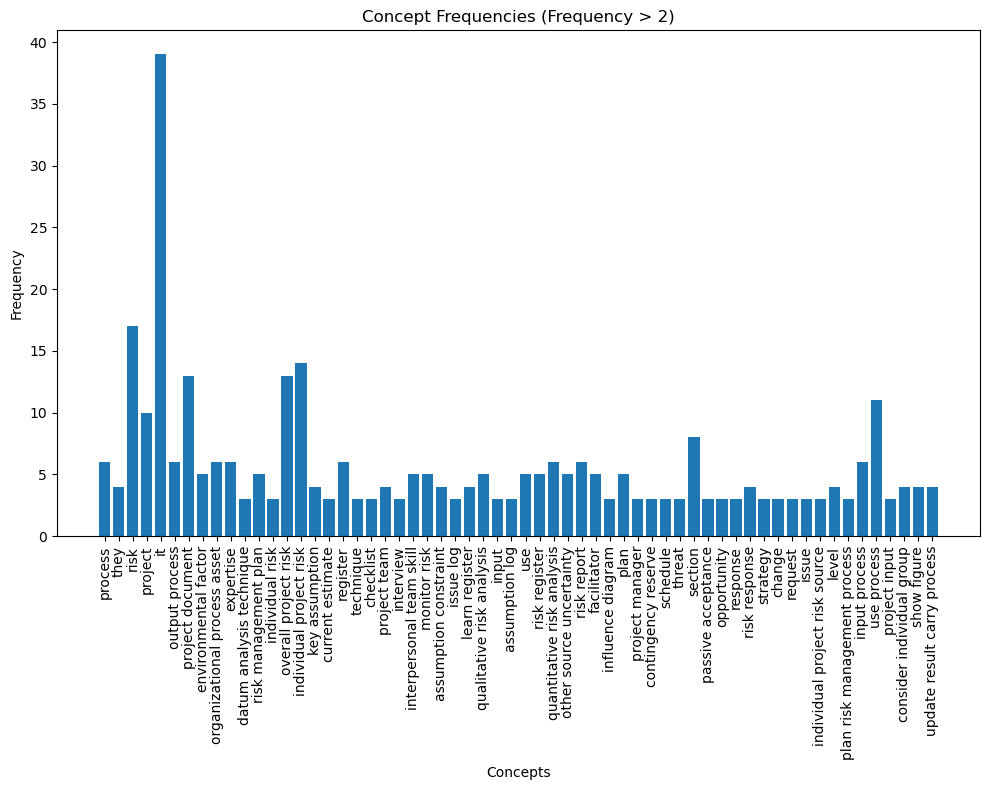

In [68]:
import matplotlib.pyplot as plt
from collections import Counter

# Your concatenated_values_reset Series
concept_freq = Counter(concatenated_values)

# Filter out concepts with frequency less than or equal to 2
filtered_concept_freq = {concept: freq for concept, freq in concept_freq.items() if freq > 2}

# Plot the filtered concept frequencies
plt.figure(figsize=(10, 8))
plt.bar(filtered_concept_freq.keys(), filtered_concept_freq.values())
plt.xlabel("Concepts")
plt.ylabel("Frequency")
plt.title("Concept Frequencies (Frequency > 2)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


#  TF-IDF(Vectorization) :

TF(t, d) = (Number of times term t appears in document d) / (Total number of terms in document d)

IDF(t, D) = log((Total number of documents in corpus D) / (Number of documents containing term t) + 1)

TF-IDF(t, d, D) = TF(t, d) * IDF(t, D)


mini function to remove any useless words:    (adding points)

In [69]:
def remove_stopwords_from_list2(text):
    
    pos_tags=pos_tagging(text)
    word_list=tokenize(text)
    # Define a list of POS tags for words to keep (e.g., nouns and adjectives)
    allowed_pos_tags = ['VBD',  # Verb, past tense
        'VBG',  # Verb, gerund or present participle
        'VBN',  # Verb, past participle
        'VBP',  # Verb, non-3rd person singular present
        'VBZ',  # Verb, 3rd person singular present
        'PRP','NN','VB',"MD", 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS']  # Nouns and adjectives
    
    # Filter out stopwords based on POS tags
    filtered_words = [word for word, pos_tag in zip(word_list, pos_tags) if pos_tag[1]
                      in allowed_pos_tags]
    
    return ' '.join(filtered_words)

In [71]:
# Assuming 'new' is your DataFrame and 'Description' is the column
documents = neww['Description'].tolist()
# Apply the clean_text function to each document
documents = [remove_stopwords_from_list2(clean_text(doc)) for doc in documents]

In [23]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(documents)

# Convert the TF-IDF matrix to a DataFrame
feature_names = vectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Display the TF-IDF DataFrame
print(df_tfidf)

    0439salefornot  395ctionepifonotkey  397theydistrfornotrisks  402part  \
0              0.0                  0.0                      0.0      0.0   
1              0.0                  0.0                      0.0      0.0   
2              0.0                  0.0                      0.0      0.0   
3              0.0                  0.0                      0.0      0.0   
4              0.0                  0.0                      0.0      0.0   
..             ...                  ...                      ...      ...   
90             0.0                  0.0                      0.0      0.0   
91             0.0                  0.0                      0.0      0.0   
92             0.0                  0.0                      0.0      0.0   
93             0.0                  0.0                      0.0      0.0   
94             0.0                  0.0                      0.0      0.0   

    403oondoieriactorsafornot  405iodistributiofornot114  413icthrepgonc  \

#  Similarity:

In [24]:
def similarity(documents):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(documents)
    
    # Calculate cosine similarity
    similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
    # Create a DataFrame for the similarity matrix
    df = pd.DataFrame(similarity_matrix, index=[f"Doc_{i}" for i in range(1, len(documents) + 1)], columns=[f"Doc_{i}" for i in range(1, len(documents) + 1)])
    
    return df

In [25]:
# Call the similarity function
similarity_matrix = similarity(documents)

# Now, similarity_matrix is a DataFrame containing the similarity matrix
print(similarity_matrix)

           Doc_1     Doc_2     Doc_3     Doc_4     Doc_5     Doc_6     Doc_7  \
Doc_1   1.000000  0.095276  0.038068  0.062450  0.069322  0.051079  0.154826   
Doc_2   0.095276  1.000000  0.230081  0.236528  0.186740  0.043175  0.229764   
Doc_3   0.038068  0.230081  1.000000  0.094349  0.074364  0.018575  0.089988   
Doc_4   0.062450  0.236528  0.094349  1.000000  0.119344  0.020908  0.217208   
Doc_5   0.069322  0.186740  0.074364  0.119344  1.000000  0.031414  0.171785   
...          ...       ...       ...       ...       ...       ...       ...   
Doc_91  0.020143  0.060924  0.032345  0.027973  0.044327  0.078275  0.149150   
Doc_92  0.065671  0.091437  0.067596  0.075472  0.104307  0.024782  0.148811   
Doc_93  0.114431  0.062029  0.028079  0.051444  0.045132  0.015094  0.148204   
Doc_94  0.076717  0.137463  0.065621  0.078353  0.100016  0.061314  0.264452   
Doc_95  0.114363  0.086226  0.038988  0.043884  0.062737  0.068599  0.169169   

           Doc_8     Doc_9    Doc_10  .

#  LDA:

In [93]:
# Create a dictionary and a corpus
id2word = corpora.Dictionary([doc.split() for doc in documents])
corpus = [id2word.doc2bow(doc.split()) for doc in documents]

# Set the number of topics
num_topics = 30  # Adjust as needed

# LDA Model
lda_model = gensim.models.LdaModel(corpus=corpus,
                                   id2word=id2word,
                                   num_topics=num_topics,
                                   random_state=100,
                                   update_every=1,
                                   chunksize=100,
                                   passes=10,
                                   alpha='auto',
                                   per_word_topics=True)

# Display topics
print(lda_model.print_topics())

NameError: name 'documents' is not defined

# Visualization of LDA

In [27]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

#  Identifying topics:

In [106]:
# Get the topics for each document
document_topics = [lda_model.get_document_topics(doc) for doc in corpus]

# Create a DataFrame to display topics for each document
df_topics = pd.DataFrame(index=range(1, len(documents) + 1))

# Iterate through the topics and populate the DataFrame
for i, topics in enumerate(document_topics, 1):
    topic_values = [topic[1] for topic in topics]
    df_topics[f'Doc_{i}'] = topic_values + [0] * (len(documents) - len(topic_values))

# Display the DataFrame with topics for each document
print(df_topics)

       Doc_1     Doc_2     Doc_3     Doc_4     Doc_5   Doc_6     Doc_7  \
1   0.909903  0.784200  0.092145  0.949245  0.954632  0.9069  0.997256   
2   0.000000  0.159642  0.860814  0.000000  0.000000  0.0000  0.000000   
3   0.000000  0.000000  0.000000  0.000000  0.000000  0.0000  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.0000  0.000000   
5   0.000000  0.000000  0.000000  0.000000  0.000000  0.0000  0.000000   
..       ...       ...       ...       ...       ...     ...       ...   
91  0.000000  0.000000  0.000000  0.000000  0.000000  0.0000  0.000000   
92  0.000000  0.000000  0.000000  0.000000  0.000000  0.0000  0.000000   
93  0.000000  0.000000  0.000000  0.000000  0.000000  0.0000  0.000000   
94  0.000000  0.000000  0.000000  0.000000  0.000000  0.0000  0.000000   
95  0.000000  0.000000  0.000000  0.000000  0.000000  0.0000  0.000000   

       Doc_8     Doc_9    Doc_10  ...    Doc_86    Doc_87    Doc_88   Doc_89  \
1   0.945279  0.943532  0.82037